In [ ]:
# you should add as many cells as you need below
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 15.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0272a547d3abfa224594ce5d813bfd795fd7229a4cb70a4adb0b05fd8a93fa7e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 14.9 MB/s 
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 new

In [ ]:
# All imports go here
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.window import Window

In [ ]:
# create a Spark session
configs = [('spark.driver.memory','8g'),
           ("spark.ui.port", "4050"),
           ('spark.cores.max', '3'),
           ('spark.executor.cores', '3'),
           ('spark.executor.memory', '8g')]
conf = SparkConf().setAll(configs)

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

In [ ]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

In [ ]:
tweets.show()

+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|                text|                 id|in_reply_to_user_id|in_reply_to_status_id|         created_at|                user|            entities|    retweeted_status|            user_id|
+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|RT @maddow: "I he...|1047999818038050816|               null|                 null|2018-10-05 00:00:02|{2017-03-22 03:11...|{[], [{16129920, ...|{1047941326975766...| 844386122822119424|
|@ChuckGrassley @S...|1047999818579292160|           10615232|                 null|2018-10-05 00:00:02|{2016-01-29 01:49...|{[], [{10615232, ...|                null|         4828166688|
|RT @cm_merlin: @f...|1048000082237247488|               nul

In [ ]:
user_tweets = tweets.select(F.col('user_id'),
                            F.col('entities.user_mentions.id').alias('mentioned_ids'),
                            F.col('retweeted_status.user.id').alias('RT_user_ids'),
                            F.col('text')).toPandas()



In [ ]:
user_tweets['user_ids'] = user_tweets[['user_id', 'RT_user_ids', 'mentioned_ids']].values.tolist()

In [ ]:
def flatten_row(t):
  flat_row = []
  for sublist in t:
    if type(sublist) == type([]):
      for item in sublist:
          if(math.isnan(item)==False):
            flat_row.append(int(item))
    else:
      if((type(sublist)== int) or (type(sublist)== float)):
        if(math.isnan(sublist)==False):
          flat_row.append(int(sublist))
  return flat_row

In [ ]:
user_tweets['user_ids']  = user_tweets['user_ids'].apply(flatten_row)
user_tweets = user_tweets[['user_ids', 'text']]
user_tweets.head()

,user_ids,text
0,"[844386122822119424, 16129920, 16129920]","RT @maddow: ""I hear a lot about about lack of ..."
1,"[4828166688, 10615232, 1249982359]",@ChuckGrassley @SenateMajLdr It's time for you...
2,"[774483262693527552, 28241597, 28241597, 14247...",RT @cm_merlin: @funder @JeffFlake @lisamurkows...
3,"[953411978, 29201047, 29201047]",RT @SenJeffMerkley: I read the FBI report. Th...
4,"[19181136, 29201047, 29201047]",RT @SenJeffMerkley: I read the FBI report. Th...


In [ ]:
mentioned_users = tweets.select(F.arrays_zip('entities.user_mentions.id', 'entities.user_mentions.screen_name').alias('temp'))\
                          .withColumn("temp", F.explode("temp"))\
                          .select(F.col("temp.id").alias("userid"), F.col("temp.screen_name").alias("screen_name"))\
                          .groupby('userid')\
                          .agg(F.first('screen_name'))\
                          .withColumnRenamed('first(screen_name)', 'screen_name').toPandas()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def get_user_tweets(username):
  userid = mentioned_users[mentioned_users['screen_name'] == username]['userid'].values[0]
  current_user_tweets = []
  for index, tweet in user_tweets.iterrows():
    if(userid in tweet['user_ids']):
      current_user_tweets.append(tweet['text'])

  return current_user_tweets


stopWords = set(stopwords.words('english'))
acceptedWords = set(nltk.corpus.words.words())
customAcceptedWords = {'maga'}
allAcceptedWords = acceptedWords.union(customAcceptedWords)

def cleanTweet(tweets):
  cleaned_tweets = []
  for tweet in tweets:
    if type(tweet) == np.float:
        return ""
    cleaned = tweet.lower()
    cleaned = re.sub("@[A-Za-z0-9_]+", "", cleaned)
    cleaned = re.sub(r'http\S+', '', cleaned)
    cleaned = re.sub('[()!?]', ' ', cleaned)
    cleaned = re.sub('\[.*?\]', ' ', cleaned)
    cleaned = re.sub("[^a-z0-9]", " ", cleaned)
    cleaned = re.sub("could", " ", cleaned)
    cleaned = re.sub("should", " ", cleaned)
    cleaned = re.sub("would", " ", cleaned)
    cleaned = re.sub("must", " ", cleaned)
    cleaned = re.sub("got", " ", cleaned)
    cleaned = re.sub("maybe", " ", cleaned)
    cleaned = re.sub("used", " ", cleaned)
    cleaned = word_tokenize(cleaned.strip())
    cleaned = [word for word in cleaned if not word.lower() in stopWords]
    cleaned = [word for word in cleaned if word.lower() in allAcceptedWords]
    cleaned = [word for word in cleaned if len(word) >= 4]
    cleaned_tweets.append(cleaned)
  return cleaned_tweets


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
import gensim.models

users = ['realDonaldTrump', 'SenWarren', 'NancyPelosi', 'AOC', 'SenSanders']
userSpecificModels = {}
commonWords = None
for user in users:
  print('Current user: {}'.format(user))
  tweetList = get_user_tweets(user)
  cleanTweets = cleanTweet(tweetList)

  model = gensim.models.Word2Vec(sentences=cleanTweets)
  userSpecificModels[user] = model
  if commonWords is None:
    commonWords = set(model.wv.vocab.keys())
  else:
    commonWords = commonWords.intersection(set(model.wv.vocab.keys()))

Current user: realDonaldTrump
Current user: SenWarren
Current user: NancyPelosi
Current user: AOC
Current user: SenSanders


In [ ]:
def getNearestWords(model, word, topn=20):
  try:
    nearest_words = model.wv.most_similar(word, topn=topn)
  except:
    nearest_words = []
  return nearest_words

In [ ]:
users = ['realDonaldTrump', 'SenWarren', 'NancyPelosi', 'SenSanders']
words = ['russia', 'election', 'china', 'wall','maga']
wlist_list = []
associations = {}
for word in words[:]:
  wlist_list = []
  print(word)
  print('-----------------')
  for user in users:
    wlist = [x[0] for x in getNearestWords(userSpecificModels[user], word)]
    wlist_list.append(wlist)
    print('{} --> {}'.format(user, wlist))
  associations[word] = wlist_list
  print('\n')

russia
-----------------
realDonaldTrump --> ['multiplicity', 'team', 'friend', 'sweeping', 'cheat', 'behest', 'sought', 'unprecedented', 'hide', 'hacking', 'reaching', 'prove', 'basically', 'substantial', 'campaign', 'showing', 'stunning', 'acting', 'awfully', 'eager']
SenWarren --> ['closed', 'tonight', 'anyone', 'rich', 'another', 'agree', 'fake', 'combat', 'equity', 'torn', 'child', 'unjust', 'presidential', 'profit', 'compromise', 'raised', 'cheat', 'chief', 'warren', 'person']
NancyPelosi --> ['anyone', 'deeply', 'world', 'exactly', 'little', 'needs', 'best', 'press', 'fake', 'middle', 'high', 'election', 'stupid', 'never', 'real', 'tweet', 'fighting', 'nation', 'news', 'left']
SenSanders --> ['time', 'trump', 'another', 'like', 'news', 'country', 'political', 'right', 'thank', 'great', 'never', 'every', 'people', 'support', 'economy', 'become', 'today', 'senate', 'socialist', 'need']


election
-----------------
realDonaldTrump --> ['corruption', 'helping', 'respect', 'theft', '

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# Creating the custom stopwords

username_dict = {'realDonaldTrump':0, 'SenWarren':1, 'NancyPelosi':2,'SenSanders':3}
def plotWordCloud(word, username):
  word_list = associations[word][username_dict[username]]
  x = ""
  for w in word_list:
    x += (" "+w)

  x = x.rstrip().lstrip()

  wordcloudimage = WordCloud(
                            max_words=100,
                            max_font_size=500,
                            font_step=2,
                            background_color='white',
                            width=1000,
                            height=720
                            ).generate(x)

  plt.figure(figsize=(15,7))
  plt.title("Tweeple about {} in context of {}".format(username, word))
  plt.axis("off")
  plt.imshow(wordcloudimage)
  wordcloudimage
  plt.show()


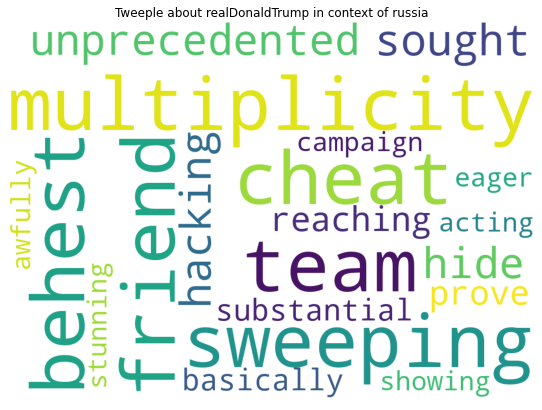

In [ ]:
plotWordCloud('russia','realDonaldTrump')

**Analysis:**

The above wordcloud shows the words associated with Donald Trump in the context of Russia. The words like 'friend','behest','campaign','hacking' indicate that there was a lot of chatter about trump working at the 'behest' of russia, acting as russia's friend, russia helping trump's 'team' for 'campaign' and russia 'hacking' the elections.

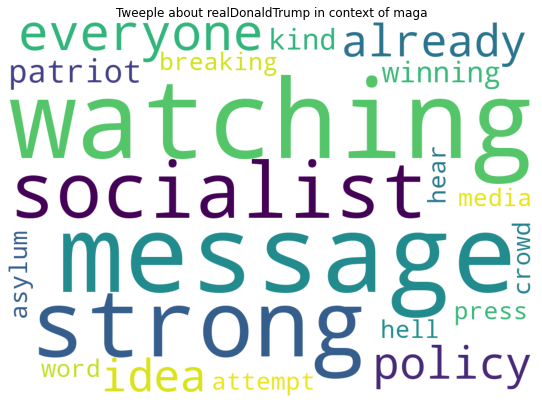

In [ ]:
plotWordCloud('maga','realDonaldTrump')

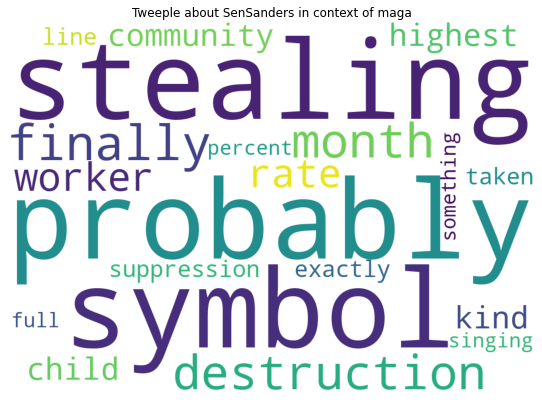

In [ ]:
plotWordCloud('maga','SenSanders')

**Analysis:**
The above two wordclouds depict somewhat contrasting sentiments of followers(users who interact with) of Trump and Sanders towards the MAGA campaign. The most used words about Trump in relation to MAGA indicate a positive sentiment with words like 'patriot', 'winning' while words with negative connotations like 'destruction', 'suppression' are used in tweets referencing Sanders in context of MAGA.

##  Question 1


What is your compelling data mining application? That is, what is it you aim to discover?

My goal was to understand the sentiments of people of twitter about popular politicians in the different contexts. For example, I tried to analyze the sentiments towards Donald Trump in the context of 'elections', 'china'.



##  Question 2

What data did you use? Describe briefly what aspects of the US Congressional data you used.

I used the tweets-sample-400k data to get information about the tweets and the users associated with it. The users associated include the person who tweets, the users mentioned, retweeting users. Then I filtered the tweets associated with a particular user to find what the tweets concerning them are saying.



##  Question 3

What embedding method did you use? And why?

I used word2vec as my goal was to find nearest words to my query keywords in the filtered set of tweets.


##  Question 4

How did you apply your embeddings to tackle the problem you posed?

After filtering the tweets associated with a user, I trained a word2vec model using the filtered tweets as the vocabulary. Then, I found the nearest words to my query words (which describe the context) using the embeddings to infer what words are used in the same context. This would give a sense of the overall sentiment of users interacting with the user in the given context. I have depicted the top closest words associated with the user in the particular context using a wordcloud.



##  Question 5

What did you discover? Provide your results and analysis here.

I was able to find some interesting word associations using the method described above. Although I don't understand or follow US politics, I tried to use the data about some popular users and some popular topics as described below. The analysis of the results is shown at the end.


